In [7]:
using DiffEQ
using Gadfly

In [1]:
type HPParam
    a1::Float64
    a2::Float64
    b1::Float64
    b2::Float64
    d1::Float64
    d2::Float64
end

The default parameters set with $b_1 = 3.0$

In [2]:
param = HPParam(5.0, 0.1, 3.0, 2.0, 0.4, 0.01)

HPParam(5.0,0.1,3.0,2.0,0.4,0.01)

In [3]:
function model(t, y, par::HPParam)
    yprime = zeros(3)
    yprime[1] = y[1]*(1.0 - y[1]) - par.a1*y[1]*y[2]/(1.0 + par.b1*y[1])
    yprime[2] = par.a1*y[1]*y[2]/(1.0 + par.b1*y[1]) - par.a2*y[2]*y[3]/(1.0 + par.b2*y[2]) - par.d1*y[2]
    yprime[3] = par.a2*y[2]*y[3]/(1.0 + par.b2*y[2]) - par.d2*y[3]
    return yprime
end

model (generic function with 1 method)

In [8]:
sol = ode45((t, x) -> model(t, x, param), [0.8, 0.2, 10.0], 0.0:10000);
# small perturburbation to initial conditions
sol_div = ode45((t, x) -> model(t, x, param), [0.81, 0.21, 10.1], 0.0:10000);

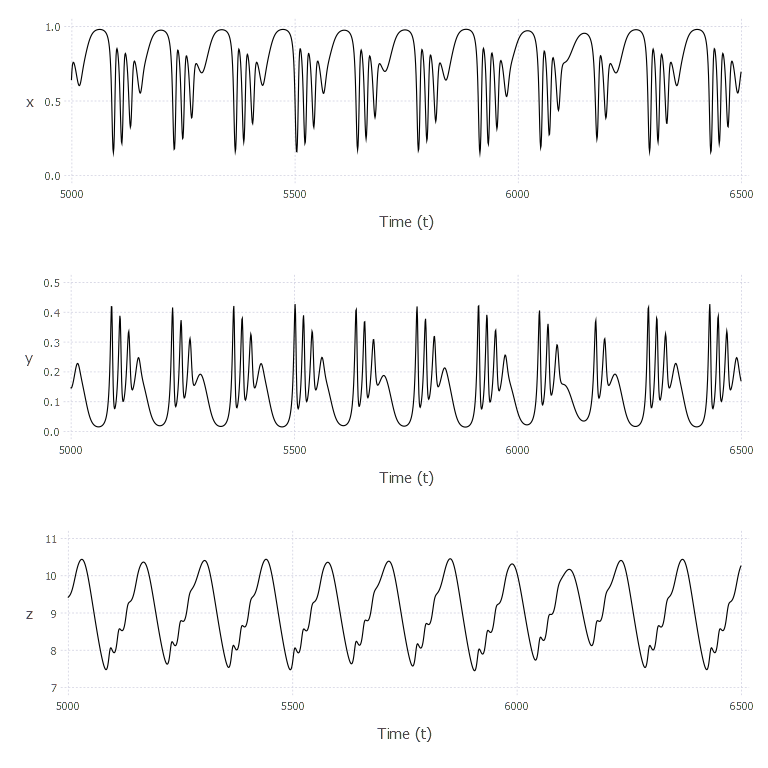

In [103]:
xlabel = Guide.xlabel("Time (t)");
xlim = Coord.Cartesian(xmin = 5000, xmax = 6500)
theme = Theme(default_color = colorant"black"); #TODO: Scale.x_continous(minvalue = 5000) doesn't work look into it
set_default_plot_size(8inch, 8inch);
p1 = plot(x = sol.x[5000:6500], y = sol.y[5000:6500, 1], xlim, xlabel, Guide.ylabel("x"), Geom.line, theme);
p2 = plot(x = sol.x[5000:6500], y = sol.y[5000:6500, 2], xlim, xlabel, Guide.ylabel("y"), Geom.line, theme);
p3 = plot(x = sol.x[5000:6500], y = sol.y[5000:6500, 3], xlim, xlabel, Guide.ylabel("z"), Geom.line, theme);
vstack(p1, p2, p3)

I don't know how to show the 3D *teacup* attractor as I need a 3D plotting package which `Gadfly.jl` doesn't support

Now we look at how small perturbations to the initial conditions lead to significant changes in the schape of the solution.

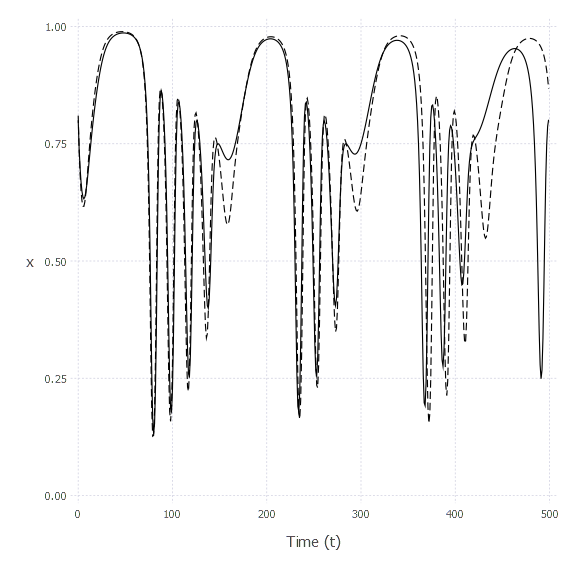

In [104]:
layer1 = layer(x = sol.x[1:500], y = sol.y[1:500, 1], Geom.line, Theme(default_color = colorant"black"));
#TODO Gadfly.jl has a symbol for :dashed but this doesn't seem to work in the call
layer2 = layer(x = sol_div.x[1:500], y = sol_div.y[1:500, 1], Geom.line, Theme(default_color = colorant"black", line_style = [2mm, 1mm]));

set_default_plot_size(6inch, 6inch)
plot(layer1, layer2, Guide.xlabel("Time (t)"), Guide.ylabel("x"))

## Bifurcation Analysis

Following the authors we will look at the local maxes for the last 5000 points (5000:10000) for changes in $b_1$ between 2.0 and 3.2 in steps of 0.01

In [73]:
function local_max(ts::AbstractVector{Float64})
    lmaxs = Float64[]
    for i in 2:(length(ts) - 3)
        if ts[i - 1] < ts[i] && ts[i] > ts[i + 1]
            push!(lmaxs, ts[i])
        end
    end
    return lmaxs
end

local_max (generic function with 2 methods)

In [120]:
##TODO: if I explictly use the "ExplicitRungeKutta" method in Mathematica this code is around 64sec/24sec = 2.6 times faster
## make this a benchmark problem. Now if I use the ParallelTable for solving the ODE I can get it so that Mathematica
## is 24/22 = 1.09 times faster. Still this is crushing ... and require that I use a C compiler for the localMax function.
function bif_analysis(b1vals)
    bparam = HPParam(5.0, 0.1, 3.0, 2.0, 0.4, 0.01)
    # the number of local maxes varies so we need a ragged array
    bpoints = []
    for b1 in b1vals
        bparam.b1 = b1
        bsol = ode45((t, y) -> model(t, y, bparam), [0.8, 0.2, 10.0], 0.0:10000)
        for m in local_max(bsol.y[5000:10000, 3])
            push!(bpoints, [b1, m])
        end
    end
    return bpoints
end

bif_analysis (generic function with 1 method)

In [121]:
@time bpoints = bif_analysis(2.2:0.001:3.2);

 23.917354 seconds (690.54 M allocations: 17.774 GB, 11.49% gc time)


In [108]:
#TODO: I don't like this, I want columns
bpoints = hcat(bpoints...);

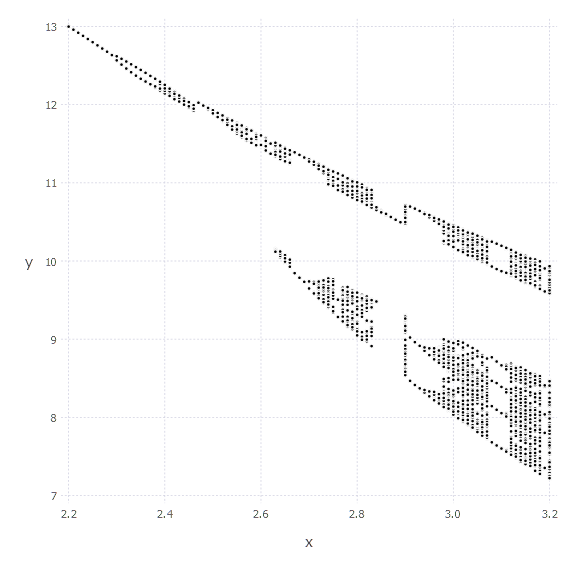

In [109]:
##TODO: I don't know how to bplot this many points ... it just crashes the IJulia notebook. Also I want to be able to
## get rid of the white outline of the point.
plot(x = bpoints[1, :], y = bpoints[2, :], Geom.point, Theme(default_color = colorant"black", default_point_size = 0.5mm))

For plotting what I really want is an array with rows [b1val, lmax] with clearly many many repeated b1val rows for each local max found.